## Validation of the Identification Measure and Couting Accidents in the catchment areas
We have now identified road segments that are prone to congestion or, at least, have many vehicles on it and thus there might be a high chance of finding accidents on these road. The aim of this notebook is two-fold. First, we want to count the number of accident on or near each identified street segment to come up with a regression framework that makes the number of accidents dependent on the number of vehicles at a given road segment. Second, we would like to get some validation for our identification strategy, by correlating the number of accidents with the RSI for each street segment.

In [11]:
# Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import osmnx as ox
import pandas as pd
import scipy.stats
import statsmodels.api as sm

from scipy.stats import linregress, spearmanr, pearsonr
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor

pd.options.mode.chained_assignment = None  # default='warn'

from config import rpath
os.chdir(rpath)

In [2]:
# Get the RSI data and print quantiles
RSI = pd.read_csv("data/RSI2.csv")
print(np.quantile(RSI.RSI, [0,.25,.5,.75,1]))

# Select only road segments which are heavily congested
RSI_small = RSI[RSI.RSI <= 0.5]

[0.         0.34798368 0.6355408  0.79916788 1.        ]


In [3]:
# Retrieve nodes and edges as geodataframe
G = ox.io.load_graphml("data/graphs/berlin-2851.graphml")
H = ox.io.load_graphml("data/graphs/Berlin-raw.graphml")
nodes, edges = ox.graph_to_gdfs(G)
edges.head()

osmid             name  \
u      v         key                                                   
172539 34694265  0                          4610047  Holländerstraße   
       34694336  0                          5117633   Gotthardstraße   
       172562    0    [31740296, 33231778, 4804202]   Gotthardstraße   
172545 271370539 0                         24973218      Teichstraße   
       28345515  0                          4546470      Teichstraße   

                        highway maxspeed  oneway   length  \
u      v         key                                        
172539 34694265  0     tertiary       50   False  237.653   
       34694336  0    secondary       50   False  687.484   
       172562    0    secondary       50   False  436.809   
172545 271370539 0     tertiary       50   False   17.179   
       28345515  0     tertiary       50   False  171.849   

                                                               geometry  \
u      v         key                                                      
172539 34694265  0    LINESTRING (13.33550 52.56521, 13.33560 52.565...   
       34694336  0    LINESTRING (13.33550 52.56521, 13.33565 52.565...   
       172562    0    LINESTRING (13.33550 52.56521, 13.33533 52.565...   
172545 271370539 0    LINESTRING (13.34661 52.56703, 13.34664 52.56688)   
       28345515  0    LINESTRING (13.34661 52.56703, 13.34659 52.567...   

                      grade  grade_abs lanes  ref bridge tunnel junction  \
u      v         key                                                       
172539 34694265  0    0.000      0.000   NaN  NaN    NaN    NaN      NaN   
       34694336  0   -0.003      0.003   NaN  NaN    NaN    NaN      NaN   
       172562    0   -0.005      0.005     2  NaN    NaN    NaN      NaN   
172545 271370539 0    0.000      0.000   NaN  NaN    NaN    NaN      NaN   
       28345515  0    0.023      0.023   NaN  NaN    NaN    NaN      NaN   

                     width access service area est_width  
u      v         key                                      
172539 34694265  0     NaN    NaN     NaN  NaN       NaN  
       34694336  0     NaN    NaN     NaN  NaN       NaN  
       172562    0     NaN    NaN     NaN  NaN       NaN  
172545 271370539 0     NaN    NaN     NaN  NaN       NaN  
       28345515  0     NaN    NaN     NaN  NaN       NaN

Since Geoff Boeings Berlin graph does not have all and / or the most recent OSM information, we merge it together with a current Berlin graph and take some information from there.

In [4]:
# MERGE TOGETHER THE G GDF WITH THE MORE INFORMATIVE H GDF AND ADD LANE INFO TO G.
H_edges = ox.graph_to_gdfs(H)[1][['osmid', 'maxspeed', 'surface', 'oneway', 'length',
       'lanes', 'maxspeed:type', 'ref', 'bridge', 'junction', 'width',
       'access', 'tunnel', 'service', 'area', 'est_width', 'geometry']]

edges = edges.join(H_edges, rsuffix="_y")

# Get lane info from H graph
edges.loc[
    (~(edges.lanes.notnull())) & (edges.lanes_y.notnull()), "lanes"
] = edges.loc[(~(edges.lanes.notnull())) & (edges.lanes_y.notnull()), "lanes_y"]

keepcols = ['osmid', 'name', 'highway', 'maxspeed', 'oneway', 'length', 'geometry',
       'grade', 'grade_abs', 'lanes', 'surface', 'maxspeed:type']
edges = edges[keepcols]

Here, we filter the whole edges dataframe to retain only those edges which are actually congested according to the RSI

In [5]:
# Get only those edges which are actually heavily congested
edges_small = edges[edges.index.isin(list(zip(RSI_small.edge_1, RSI_small.edge_2, np.zeros(len(RSI_small),dtype=int))))]
edges_small.reset_index(inplace=True)

edges_small['u'] = edges_small['u'].astype(str)
edges_small['v'] = edges_small['v'].astype(str)
edges_small["edge_id"] = edges_small[['u', 'v']].agg('-'.join, axis=1)
edges_small = edges_small.merge(RSI_small, on="edge_id")

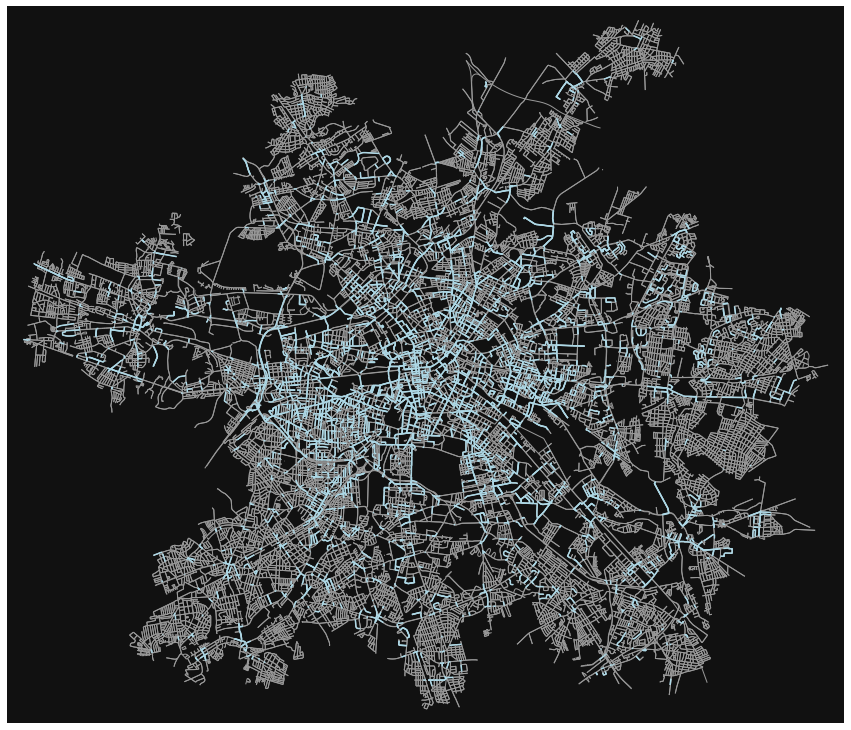

In [6]:
# Plot the streets
fig, ax = ox.plot_graph(G, close=False, show=False, node_color='w',
                        node_size=0,edge_linewidth=1, figsize=(15,15))#,
                        #bgcolor='#FFFFFF',)

# Plot the edges
edges_small.plot(ax=ax, facecolor='none', color="#add8e6")
plt.show()

## Create a buffer around edge segments
Here, we take the edge segments and create a 100m buffer ("catchment area") around them to then be able to count incidents within these buffers.

In [7]:
# Make a geodataframe, project it
edges_buffered = gpd.GeoDataFrame(edges_small, geometry="geometry").set_crs(4326).to_crs(25833)

# Create the buffer and revert to WGS84
buffersize = 100 # in meters
edges_buffered["geometry"] = edges_buffered.geometry.buffer(buffersize)
edges_buffered = edges_buffered.to_crs(4326)

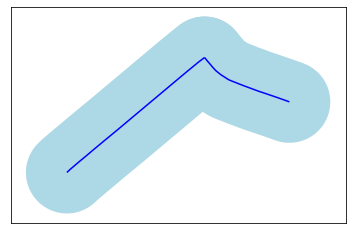

In [8]:
fig, ax = plt.subplots(1,1)
edges_buffered.to_crs(25833).iloc[:2,:].plot(ax=ax, color="lightblue")
edges_small.to_crs(25833).iloc[:2,:].plot(ax=ax, color="blue")
ax.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
# print(edges_small.iloc[:2,:])
# edges_small.iloc[:2,:][["u","v","geometry"]].to_file("street-buffer-example-1.geojson", driver="GeoJSON")
# edges_buffered.iloc[:2,:][["u","v","geometry"]].to_file("street-buffer-example-2.geojson", driver="GeoJSON")

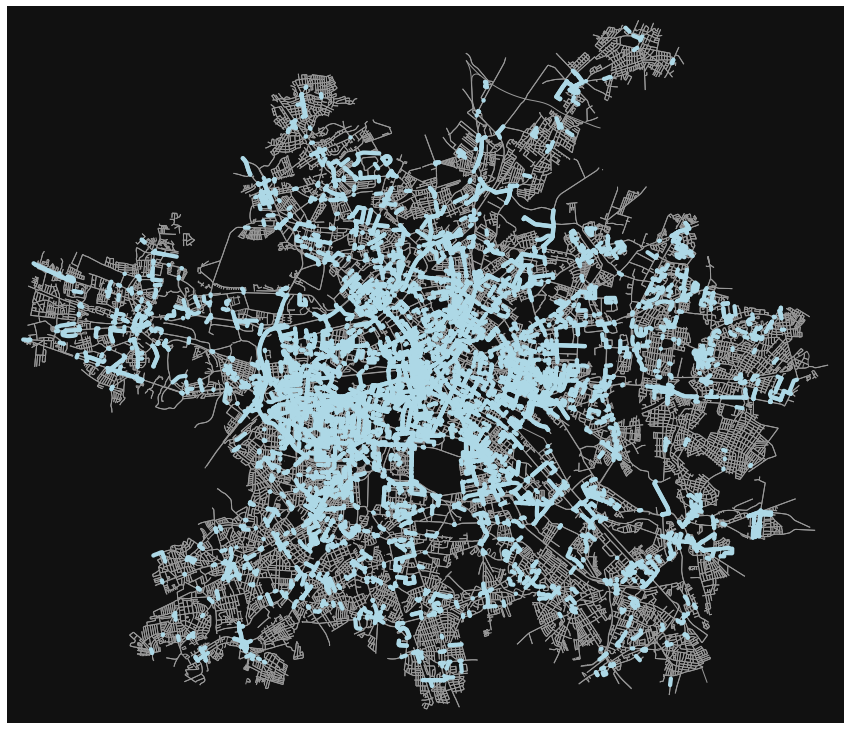

In [9]:
# Plot it
fig, ax = ox.plot_graph(G, close=False, show=False, node_color='w', node_size=0,
                        edge_linewidth=1, figsize=(15,15))#, bgcolor="#FFFFFF")
edges_buffered.geometry.plot(ax=ax,facecolor='none', color="#add8e6")
plt.show()

## Adding Incident data
Here, we read in the incident data, filter for accidents only and only for accidents happening in the specified time windows.

In [65]:
print(incid.head())
z = incid.head()["start_timestamp_CET"] = pd.to_datetime(
    incid.head()["Earliest.Start.Time.local."].apply(lambda x: x.split("+")[0]),
    format='%Y-%m-%dT%H:%M:%S'
).dt.tz_localize('CET')
z

                            Incident.Id  severity  Road.Closure  \
1  9ea41d63-6587-4891-b2aa-1efe5dcdc493         4          True   
2  09cc6edc-5866-461e-96c2-2750ac845506         3         False   
3  1a73dd40-8189-4ea3-aa96-52a621965380         2         False   
4  26f389ec-0d89-4b43-93b1-b5ce6a15e18d         3          True   
5  b5b0d30e-89ee-4656-a9fa-8f7e0dd007a6         2         False   

     Category.Ids                                        Description  Planned  \
1  1-Construction  Road closed due to construction on Grenzallee ...     True   
2  1-Construction  Lane closed and speed restriction due to bridg...     True   
3  1-Construction  Roadway reduced from  lanes to one lane due to...     True   
4  1-Construction  Road closed due to construction on Seegefelder...     True   
5  1-Construction  Roadway reduced from  lanes to one lane due to...     True   

  Earliest.Start.Time.local.     Latest.End.Time.local.  Direction  \
1  2014-10-22T08:51:28+02:00  2017-12-24

1   2014-10-22 08:51:28+02:00
2   2014-12-19 13:23:25+01:00
3   2015-04-22 11:23:06+02:00
4   2016-12-30 10:20:15+01:00
5   2015-11-26 22:38:21+01:00
Name: Earliest.Start.Time.local., dtype: datetime64[ns, CET]

In [10]:
# Nolan's filter accidents by 'reason2', mine by strings in certain variables. Mine is more restrictive
filter_type = "my" # "nolan". 

# Read incident data
incid = pd.read_csv("data/Berlin_2017/incidence_21_08_13a.csv", encoding="ISO-8859-1", index_col=0)

# Create a dummy vector to feed into the "ambiguous" argument one step below. 
# It basically stores whether or not something is in summer or winter time.
tf = incid["Latest.End.Time.local."].apply(lambda x: x.split("+")[1][1]) 
tf = (tf == '2')

# Convert timestamp to datetime objects
incid["start_timestamp_CET"] = pd.to_datetime(
    incid["Earliest.Start.Time.local."].apply(lambda x: x.split("+")[0]),
    format='%Y-%m-%dT%H:%M:%S'
).dt.tz_localize('CET') 
incid["end_timestamp_CET"] = pd.to_datetime(
    incid["Latest.End.Time.local."].apply(lambda x: x.split("+")[0]),
    format='%Y-%m-%dT%H:%M:%S'
).dt.tz_localize('CET', ambiguous=tf) # ambiguous parameter for when the

# Filter dataframe to only include peak hours during weekdays
incid = incid[(incid.start_timestamp_CET.dt.weekday < 5) | (incid.end_timestamp_CET.dt.weekday < 5) ] # 5 = Saturday, 6 = Sunday
incid = incid[((incid.start_timestamp_CET.dt.hour >= 6) & (incid.start_timestamp_CET.dt.hour < 10)) |
          ((incid.start_timestamp_CET.dt.hour >= 14) & (incid.start_timestamp_CET.dt.hour < 20)) |
          ((incid.end_timestamp_CET.dt.hour >= 6) & (incid.end_timestamp_CET.dt.hour < 10)) |
          ((incid.end_timestamp_CET.dt.hour >= 14) & (incid.end_timestamp_CET.dt.hour < 20))]

# Filter to include only accidents
if filter_type=="nolan":
    incid = incid[incid["reason2"]]
else:
    incid = incid[(incid['Description'].str.contains('[Aa]ccident',na=False))|
                  (incid['Event.Text'].str.contains('[Aa]ccident',na=False))]

# Make GDF
incid = gpd.GeoDataFrame(incid, geometry=gpd.points_from_xy(incid.lon, incid.lat)).set_crs(4326)    

# Only keep Accidents within berlin_uc
berlin_uc = gpd.read_file("data/geodata/GHS/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")
berlin_uc = berlin_uc[berlin_uc.UC_NM_MN=="Berlin"][["UC_NM_MN","geometry"]]

incid = gpd.sjoin(incid, berlin_uc, how="left", op="intersects")
incid = incid[incid.UC_NM_MN=="Berlin"].drop(columns=["UC_NM_MN", "index_right"])

incid.head()

,Incident.Id,severity,Road.Closure,Category.Ids,Description,Planned,Earliest.Start.Time.local.,Latest.End.Time.local.,Direction,Event.Text,...,highway,start,end,startdate,enddate,startbezirk,startbezkey,start_timestamp_CET,end_timestamp_CET,geometry
98,289aa381-259c-47a9-a03d-6dcc048100f8,3,True,4-Incident,Road closed due to accident on Mariendorfer We...,False,2017-01-02T13:56:30+01:00,2017-01-02T17:56:30+01:00,Both ways,"Road closed, accident",...,False,2017-01-02T13:56:30,2017-01-02T17:56:30,2017-01-02 13:56:30,2017-01-02 17:56:30,Neukölln,8,2017-01-02 13:56:30+01:00,2017-01-02 17:56:30+01:00,POINT (13.43291 52.46470)
104,8183292b-6296-4448-b5f4-fc1a915d2bc1,3,False,4-Incident,Roadway reduced from lanes to one lane due to...,False,2017-01-02T16:13:39+01:00,2017-01-02T20:13:39+01:00,Both ways,"Accident, roadway reduced from lanes to one lane",...,False,2017-01-02T16:13:39,2017-01-02T20:13:39,2017-01-02 16:13:39,2017-01-02 20:13:39,Spandau,5,2017-01-02 16:13:39+01:00,2017-01-02 20:13:39+01:00,POINT (13.18474 52.51547)
150,65e2e901-45e4-4b01-bfd5-48517de5c112,4,True,4-Incident,Road closed due to accident on B96 Mehringdamm...,False,2017-01-03T19:50:18+01:00,2017-01-03T23:50:18+01:00,Northbound,"Road closed, accident",...,False,2017-01-03T19:50:18,2017-01-03T23:50:18,2017-01-03 19:50:18,2017-01-03 23:50:18,Friedrichshain-Kreuzberg,2,2017-01-03 19:50:18+01:00,2017-01-03 23:50:18+01:00,POINT (13.38767 52.49295)
164,b2f49ded-01fc-45cb-a0b2-5b1ee4edf91d,4,False,4-Incident,Lane closed due to accident on A111 Northbound...,False,2017-01-04T06:35:45+01:00,2017-01-04T10:35:45+01:00,Northbound,"Lane (or Lanes) closed, accident",...,True,2017-01-04T06:35:45,2017-01-04T10:35:45,2017-01-04 06:35:45,2017-01-04 10:35:45,Reinickendorf,12,2017-01-04 06:35:45+01:00,2017-01-04 10:35:45+01:00,POINT (13.31069 52.56524)
166,694c5548-7f0f-4c6d-94d6-826470765409,4,False,4-Incident,Lane closed due to accident on A100 Eastbound ...,False,2017-01-04T06:53:15+01:00,2017-01-04T10:53:15+01:00,Eastbound,"Lane (or Lanes) closed, accident",...,True,2017-01-04T06:53:15,2017-01-04T10:53:15,2017-01-04 06:53:15,2017-01-04 10:53:15,Tempelhof-Schöneberg,7,2017-01-04 06:53:15+01:00,2017-01-04 10:53:15+01:00,POINT (13.36914 52.47136)


Number of accidents: 792


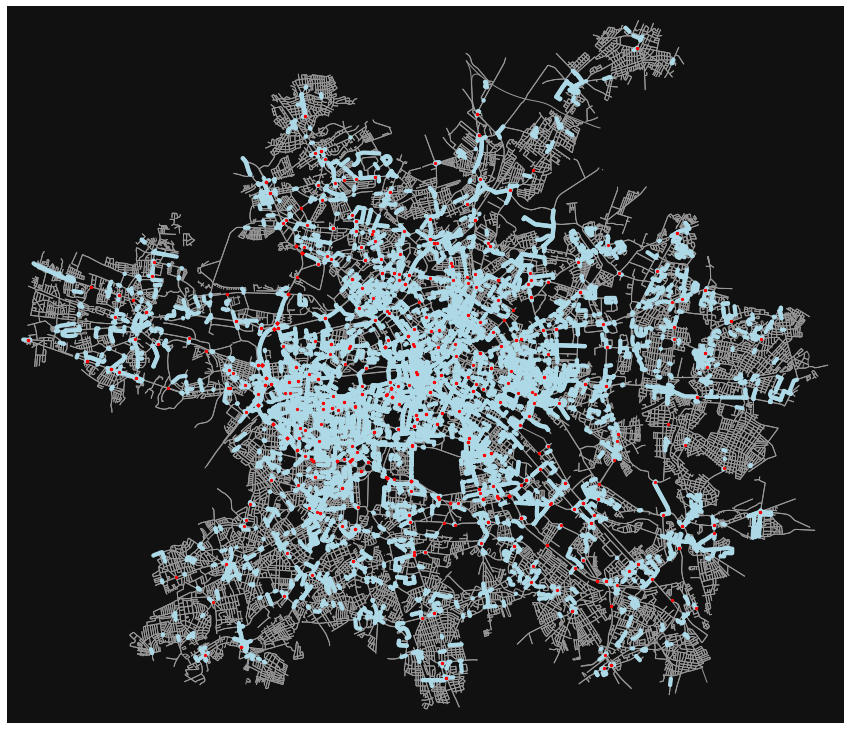

In [11]:
# Print Number of accidents
print("Number of accidents:", len(incid))

# Make a gdf
incid = gpd.GeoDataFrame(incid, geometry=gpd.points_from_xy(incid.lon, incid.lat)).set_crs(4326)

# Plot the network
fig, ax = ox.plot_graph(G, close=False, show=False, node_color='w', node_size=0,edge_linewidth=1, figsize=(15,15))#, bgcolor="white")

# Plot the edges and incidents
edges_buffered.geometry.plot(ax=ax,facecolor='none', color="#add8e6")
incid.geometry.plot(ax=ax,facecolor='red', color="red", markersize=5)
plt.show()

### Validation: Spearman's rho accidents vs. RSI

In the following, we take all the edges into account for which we have an RSI value. We then count the accidents on every edge and finally compute Spearman's rank correlation coefficient of RSI vs. number of accidents

In [38]:
# Get all edges and convert to Geodataframe, project
edges_buffered_all = gpd.GeoDataFrame(edges, geometry="geometry").set_crs(4326).to_crs(25833).reset_index()
edges_buffered_all['u'] = edges_buffered_all['u'].astype(str)
edges_buffered_all['v'] = edges_buffered_all['v'].astype(str)
edges_buffered_all["edge_id"] = edges_buffered_all[['u', 'v']].agg('-'.join, axis=1)
edges_buffered_all = edges_buffered_all.merge(RSI, on="edge_id")
edges_buffered_all = edges_buffered_all.dropna(subset=["RSI"]) # Drop all edges without RSI value

# Create the buffer and revert to WGS84
buffersize = 100 # in meters
edges_buffered_all["geometry"] = edges_buffered_all.geometry.buffer(buffersize)
edges_buffered_all = edges_buffered_all.to_crs(4326)

# Join with accident data
edges_buffered_all_accidents = gpd.sjoin(edges_buffered_all, incid, how="left", op="intersects")

# Count accidents on edges
edges_buffered_all_accidents["n_accidents"] = edges_buffered_all_accidents["Incident.Id"].groupby(
    edges_buffered_all_accidents.edge_id
).transform('count')
edges_buffered_all_accidents = edges_buffered_all_accidents.groupby("edge_id").agg("first").reset_index()

# Make categorical RSI
edges_buffered_all_accidents["RSI_cat"] = pd.cut(edges_buffered_all_accidents.RSI,
                                       bins=[-1,0.5,1.01],
                                       labels=[0,1])

# Calculate Spearman's Rho
print(spearmanr(edges_buffered_all_accidents.RSI, edges_buffered_all_accidents.n_accidents, alternative='less'))
print(spearmanr(edges_buffered_all_accidents.RSI_cat, edges_buffered_all_accidents.n_accidents, alternative='less'))

SpearmanrResult(correlation=-0.15586657156142486, pvalue=1.318004246579837e-125)
SpearmanrResult(correlation=-0.13483132681048965, pvalue=2.8493479362559046e-94)


Finally, we save the edge list with the appended accident number and RSI.

In [276]:
# edges_buffered_all_accidents.to_csv("data/edges_buffered_all_accidents.csv", index=False)

### Validation: Weather data

In [40]:
# Get Berlin UC Bounding Box
berlin_uc = gpd.read_file("data/geodata/GHS/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")
berlin_uc = berlin_uc[berlin_uc.UC_NM_MN=="Berlin"][["UC_NM_MN","geometry"]]
berlin_uc = berlin_uc.bounds

In [41]:
keepcols = ["sensor_id", "lat", "lon", "P1", "P2", "timestamp"]
path = "data/Luftdaten"
files = os.listdir(path)
files = [f for f in files if f.endswith("sds011.csv")]

def read_PM_data(file):
    '''Function to read PM data files and filter them down to only include data from Berlin'''
    x = pd.read_csv(os.path.join(path, file), sep=";")[keepcols]
    x = x[(x.lon >= berlin_uc.minx.iloc[0]) & (x.lon <= berlin_uc.maxx.iloc[0]) &
          (x.lat >= berlin_uc.miny.iloc[0]) & (x.lat <= berlin_uc.maxy.iloc[0])]
    return x

In [42]:
# Read Luftdaten files and combine into one big Luftdaten df
for i, file in enumerate(files):
    # Read full data
    print("Processing file", file)
    if i == 0:
        full = read_PM_data(file)
    else:
        full = full.append(read_PM_data(file))

Processing file 2017-01_sds011.csv
Processing file 2017-06_sds011.csv
Processing file 2017-12_sds011.csv
Processing file 2017-04_sds011.csv
Processing file 2017-11_sds011.csv
Processing file 2017-07_sds011.csv
Processing file 2017-05_sds011.csv
Processing file 2017-10_sds011.csv
Processing file 2017-09_sds011.csv
Processing file 2017-02_sds011.csv
Processing file 2017-03_sds011.csv
Processing file 2017-08_sds011.csv


In [43]:
# Aggregate PM2.5 and PM10 values over the whole year (mean and sum)
luft = full.groupby(["sensor_id", "lat", "lon"]).agg(["mean", "sum"]).reset_index()
luft.columns = ["sensor_id", "lat", "lon", "PM25_mean", "PM25_sum", "PM10_mean", "PM10sum"]
luft = gpd.GeoDataFrame(luft, geometry=gpd.points_from_xy(luft.lon, luft.lat)).set_crs(4326).to_crs(25833)
luft.head()
luft["old_geometry"] = luft["geometry"]

In [44]:
edges_buffered_all = gpd.GeoDataFrame(edges, geometry="geometry").set_crs(4326).to_crs(25833).reset_index()
edges_buffered_all['u'] = edges_buffered_all['u'].astype(str)
edges_buffered_all['v'] = edges_buffered_all['v'].astype(str)
edges_buffered_all["edge_id"] = edges_buffered_all[['u', 'v']].agg('-'.join, axis=1)
edges_buffered_all = edges_buffered_all.merge(RSI, on="edge_id")
edges_buffered_all = edges_buffered_all.dropna(subset=["RSI"]) # Drop all edges without RSI value

In [45]:
luft["geometry"] = luft.old_geometry.buffer(100)

In [46]:
edges_buffered_all = edges_buffered_all.to_crs(25833)

In [47]:
x = gpd.sjoin(edges_buffered_all, luft, how="left", op="intersects")

In [48]:
x = x.dropna(subset=["lat"])

In [49]:
x["edge_id"] = x.u.astype(str)+"-"+x.v.astype(str)

In [50]:
x = x[["edge_id","u","v", "RSI", "PM25_mean", "PM25_sum", "PM10_mean", "PM10sum", "geometry"]].groupby(["edge_id", "u","v"]).agg("mean").reset_index()

In [59]:
y = x.copy()
y["RSI_cat"] = pd.cut(x.RSI, [-1,.5,1.01], labels=[0,1])

In [60]:
print(pearsonr(x.RSI, x.PM25_mean))
pearsonr(x.RSI, x.PM10_mean)

(0.04041461318397911, 0.3046910620332367)


(0.0077447892767167105, 0.8441249348004497)

In [61]:
print(pearsonr(y.RSI_cat, y.PM25_mean))
pearsonr(y.RSI_cat, y.PM10_mean)

(0.03560357057622845, 0.365913314739506)


(0.007285477157184573, 0.8532612533408327)

## Validation: RSI correlation with betweenness

In [30]:
# Retrieve nodes and edges as geodataframe
G = ox.io.load_graphml("data/graphs/berlin-2851.graphml")
H = G.to_undirected()

In [32]:
dic = ''
with open(r'data/berlin_uc_edge_betweenness_weighted.json','r') as f:
         for i in f.readlines():
            dic = i #string
edge_betweenness_weighted = eval(dic)

multi_edge_betweenness_weighted = dict()
nx.set_edge_attributes(H, multi_edge_betweenness_weighted, name="betweenness_weighted")

for key in edge_betweenness_weighted.keys():
    new_key = (key[0],key[1],0)
    multi_edge_betweenness_weighted[new_key] = edge_betweenness_weighted[key]
    
nx.set_edge_attributes(H, multi_edge_betweenness_weighted, name="betweenness_weighted")

In [58]:
H_edges = ox.graph_to_gdfs(H, nodes=False).reset_index()
H_edges2 = H_edges.copy()
H_edges2["u"] = H_edges["v"]
H_edges2["v"] = H_edges["u"]
H_edges = H_edges.append(H_edges2)
H_edges['u'] = H_edges['u'].astype(str)
H_edges['v'] = H_edges['v'].astype(str)
H_edges["edge_id"] = H_edges[['u', 'v']].agg('-'.join, axis=1)
H_edges = H_edges.merge(RSI_small, on="edge_id").dropna(subset=["RSI", "betweenness_weighted"])

In [59]:
print(len(H_edges))

8018


In [60]:
pearsonr(H_edges.RSI, H_edges.betweenness_weighted)

(0.02127004206454425, 0.056844063061895274)

## Old: Regressions of PM25 on RSI and volume

In [136]:
x["RSI"] = x["RSI"]*10
x["RSI_2"] = x["RSI"]**2

# Read RV data with n data for edge ids and time ids
Rv = pd.read_csv("data/Rv.csv", names = ['edge_id', 'time_id', 'n', 'speed', 'meanspeed'], skiprows=4)

# Take the sum over all times to get total n per year on edge
Rv = Rv["n"].groupby(Rv["edge_id"]).sum().reset_index()
Rv.rename(columns={"n":"flow_n"}, inplace=True)

# Merge with dataframe
x = x.merge(Rv, on="edge_id")
x["log_flow_n"] = np.log(x["flow_n"])
x["log_flow_n_2"] = x["log_flow_n"]**2

/home/nikoch/.conda/envs/ma2/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


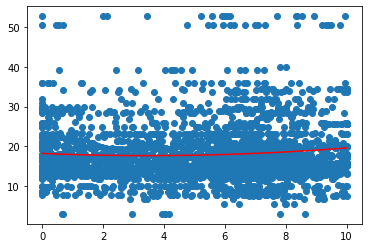

In [116]:
linmod = sm.OLS(x.PM25_mean,sm.add_constant(x[["RSI", "RSI_2"]]))
res = linmod.fit()
xrange = np.linspace(x.RSI.min(), x.RSI.max(), 100)
plt.scatter(x.RSI,x.PM25_mean)
plt.plot(xrange, res.params[0] + res.params[1]*xrange + res.params[2]*np.power(xrange,2), color="red")

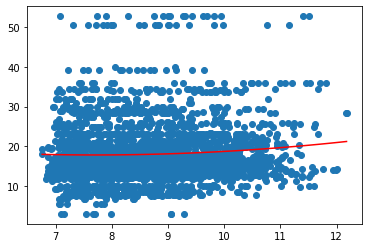

In [143]:
linmod = sm.OLS(x.PM25_mean,sm.add_constant(x[["log_flow_n", "log_flow_n_2"]]))
res = linmod.fit()
xrange = np.linspace(x.log_flow_n.min(), x.log_flow_n.max(), 100)
plt.scatter(x.log_flow_n,x.PM25_mean)
plt.plot(xrange, res.params[0] + res.params[1]*xrange + res.params[2]*np.power(xrange,2), color="red")

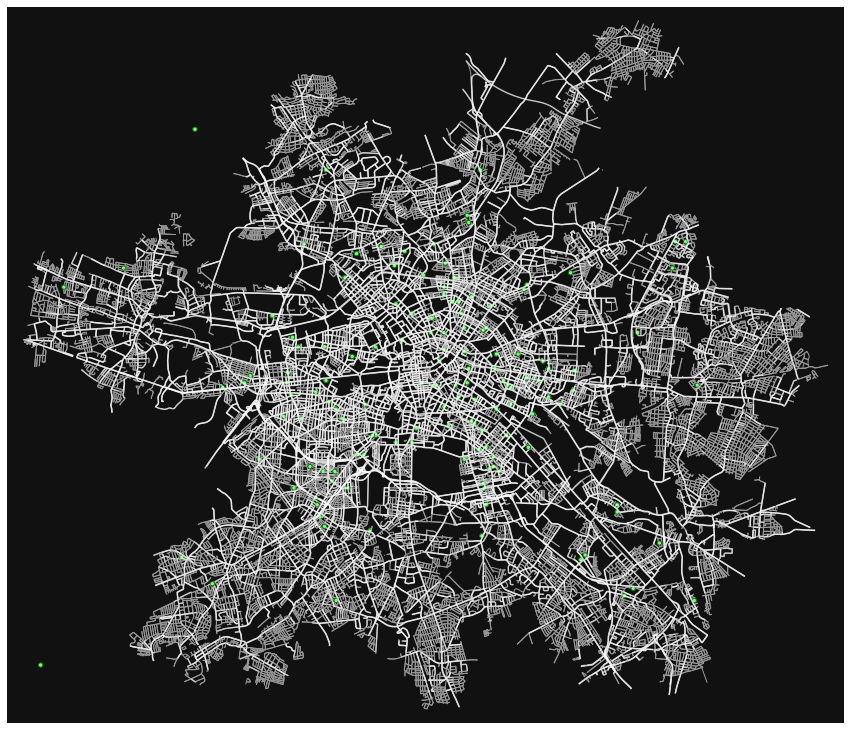

In [161]:
# Plot the network
fig, ax = ox.plot_graph(G, close=False, show=False, node_color='w', node_size=0,edge_linewidth=1, figsize=(15,15))#, bgcolor="white")

# Plot the edges and incidents
edges_buffered_all.to_crs(4326).geometry.plot(ax=ax, color="white", alpha=0.5)
luft.to_crs(4326).geometry.plot(ax=ax,facecolor="lightgreen", edgecolor="green")
plt.show()